<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Predicting_Deaths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
!pip install -U tensorflow-addons
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from keras.layers import LayerNormalization
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
import tensorflow
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical
import random



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
data = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

data = pd.DataFrame(data)

# select Thailand only
data = data.loc[data['CountryName'] == "Thailand"]

# select columns
data = data[["Date", "ConfirmedDeaths"]]

# change date format
data.Date =  pd.to_datetime(data["Date"], format='%Y%m%d')

# reset index
data = data.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["ConfirmedDeaths"]] = data[["ConfirmedDeaths"]].replace(np.nan, 0)

# remove NaN rows (bottom part)
data = data.dropna()

# add daily cases columns
data[["Deaths_daily"]] = data['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Deaths_daily
data[["Deaths_daily"]] = data[["Deaths_daily"]].replace(np.nan, 0)


# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# remove the last rows with incomplete info
data = data.loc[~(data[["ConfirmedDeaths"]]==0).all(axis=1)]

# reset index
data = data.reset_index(drop = True)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
mob = read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")

mob = pd.DataFrame(mob)

# select only Thailand
mob = mob.loc[mob['country_region'] == "Thailand"]

# select columns
mob = mob[["date", "residential_percent_change_from_baseline"]]

# change date format
mob.date =  pd.to_datetime(mob["date"])

# change column name
mob = mob.rename(columns = {'date':'Date', "residential_percent_change_from_baseline":"resident"})

# reset index
mob = mob.reset_index(drop = True)

# start from 15/6/2021
mob = mob[mob.loc[mob['Date'] == "2021-06-15"].index[0]:]

# reset index
mob = mob.reset_index(drop = True)

# omit Date column
mob = mob.drop(["Date"], axis = 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
# whichever has fewer data
length = min(len(data), len(mob))

# Deaths daily
data_d = pd.concat([data.Deaths_daily[:length], 
                    data.Date[:length],
                    mob[:length]], axis = 1)

data_d = data_d.rename(columns = {"Deaths_daily":"data_d"})
# data_d = data_d[data_d.loc[data_d['Date'] == "2021-06-15"].index[0]:]

# drop date column
data_d = data_d.drop(["Date"], axis = 1)

In [ ]:
case = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

case = pd.DataFrame(case)

# select Thailand only
case = case.loc[case['CountryName'] == "Thailand"]

case = case[["Date", "ConfirmedDeaths"]]

# change date format
case.Date =  pd.to_datetime(case["Date"], format='%Y%m%d')

# reset index
case = case.reset_index(drop = True)

# replace NaN with 0 for ConfirmedDeaths
case[["ConfirmedDeaths"]] = case[["ConfirmedDeaths"]].replace(np.nan, 0)

# add daily cases columns
case[["Deaths_daily"]] = case['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Deaths_daily
case[["Deaths_daily"]] = case[["Deaths_daily"]].replace(np.nan, 0)

# start from 15/6/2021
case = case[case.loc[case['Date'] == "2021-06-15"].index[0]:]

# reset index
case = case.reset_index(drop = True)

# remove the last rows with incomplete info
case = case.loc[~(case[["ConfirmedDeaths"]]==0).all(axis=1)]

actual = case[case.loc[case['Date'] == "2021-06-15"].index[0]:]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
# use the previous 14 days to predict the next day
lag = 14
prediction = 1
window = 3 # for moving average
index = 30

data_d['data_d'] = data_d.data_d.rolling(window).mean()

data_d.dropna(subset = ["data_d"], inplace=True) # remove the first 2 rows

data_d = data_d.reset_index(drop = True)

# confirmed deaths
nrow_total = data_d.shape[0] - lag - prediction + 1
input_list = [np.expand_dims(data_d[i:lag+i], axis=0) for i in range(nrow_total)] 
X_d_p = np.concatenate(input_list, axis=0)

y_d_p = np.array([data_d.data_d[lag:data_d.shape[0]]])
y_d_p = y_d_p.T # transpose the matrix


# split into training and test sets
X_d_p_tr = X_d_p[0:index+1, :, :]
X_d_p_ts = X_d_p[index+1:data_d.shape[0], :, :]

y_d_p_tr = y_d_p[0:index+1]
y_d_p_ts = y_d_p[index+1:data_d.shape[0]]


In [ ]:
def split_sequence(sequence, lag):
  x, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + lag
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    x.append(seq_x)
    y.append(seq_y)
  return array(x), array(y)



In [ ]:
# resident (univariate)

# confirmed cases
x_mob, y_mob = split_sequence(data_d.resident, lag)

# split into training and test sets
X_tr_resident = x_mob[0:index+1, :]
X_ts_resident = x_mob[index+1:x_mob.shape[0], :]
X_tr_resident = X_tr_resident.reshape(X_tr_resident.shape[0], X_tr_resident.shape[1], 1) # reshape input into 3D
X_ts_resident = X_ts_resident.reshape(X_ts_resident.shape[0], X_ts_resident.shape[1], 1)

y_tr_resident = y_mob[0:index+1]
y_ts_resident = y_mob[index+1:x_mob.shape[0]]
y_tr_resident = y_tr_resident.reshape(y_tr_resident.shape[0], 1, 1) # reshape output into 3D
y_ts_resident = y_ts_resident.reshape(y_ts_resident.shape[0], 1, 1) 

## Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 


In [ ]:
# Multivariate CNN confirmed deaths
kernel = [3, 5, 7]
pool = [2]
cnn_d_multi = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_p_tr, y_d_p_tr)
    cnn_d_multi.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_p_tr, y_d_p_tr)
    cnn_d_multi.append(score)

cnn_d_multi = pd.DataFrame(cnn_d_multi).T
cnn_d_multi.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 11.513
filter = 4, kernel size = 3, pooling size = 2: 12.077
filter = 8, kernel size = 3, pooling size = 2: 9.970
filter = 16, kernel size = 3, pooling size = 2: 7.790
filter = 32, kernel size = 3, pooling size = 2: 8.695
filter = 64, kernel size = 3, pooling size = 2: 7.547
filter = 128, kernel size = 3, pooling size = 2: 8.525
filter = 256, kernel size = 3, pooling size = 2: 11.184
filter = 512, kernel size = 3, pooling size = 2: 11.338
filter = 1024, kernel size = 3, pooling size = 2: 11.531
filter = 2, kernel size = 5, pooling size = 2: 10.210
filter = 4, kernel size = 5, pooling size = 2: 10.278
filter = 8, kernel size = 5, pooling size = 2: 7.242
filter = 16, kernel size = 5, pooling size = 2: 9.702
filter = 32, kernel size = 5, pooling size = 2: 7.634
filter = 64, kernel size = 5, pooling size = 2: 8.848
filter = 128, kernel size = 5, pooling size = 2: 9.589
filter = 256, kernel size = 5, pooling size = 2: 12.363
filter = 512, kerne

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

# Multivariate LSTM confirmed deaths

lstm_d_multi = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_p_tr, y_d_p_tr, i)
  lstm_d_multi.append(score)

### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate GRU confirmed deaths

gru_d_multi = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_p_tr, y_d_p_tr, i)
  gru_d_multi.append(score)

### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# Multivariate RNNs confirmed deaths

rnn_d_multi = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_p_tr, y_d_p_tr, i)
  rnn_d_multi.append(score)

### Result Table

#### Multivariate Confirmed Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi[0],3), 
                                     round(gru_d_multi[0],3),
                                     round(rnn_d_multi[0],3), 
                                     round(cnn_d_multi.iloc[0,0],3),
                                     round(cnn_d_multi.iloc[0,1],3),
                                     round(cnn_d_multi.iloc[0,2],3),
                                     round(cnn_d_multi.iloc[0,3],3),
                                     round(cnn_d_multi.iloc[0,4],3),
                                     round(cnn_d_multi.iloc[0,5],3)],
                                     [round(lstm_d_multi[1],3), 
                                     round(gru_d_multi[1],3),
                                     round(rnn_d_multi[1],3), 
                                     round(cnn_d_multi.iloc[1,0],3),
                                     round(cnn_d_multi.iloc[1,1],3),
                                     round(cnn_d_multi.iloc[1,2],3),
                                     round(cnn_d_multi.iloc[1,3],3),
                                     round(cnn_d_multi.iloc[1,4],3),
                                     round(cnn_d_multi.iloc[1,5],3)],
                                     [round(lstm_d_multi[2],3), 
                                     round(gru_d_multi[2],3),
                                     round(rnn_d_multi[2],3), 
                                     round(cnn_d_multi.iloc[2,0],3),
                                     round(cnn_d_multi.iloc[2,1],3),
                                     round(cnn_d_multi.iloc[2,2],3),
                                     round(cnn_d_multi.iloc[2,3],3),
                                     round(cnn_d_multi.iloc[2,4],3),
                                     round(cnn_d_multi.iloc[2,5],3)],
                                     [round(lstm_d_multi[3],3), 
                                     round(gru_d_multi[3],3),
                                     round(rnn_d_multi[3],3), 
                                     round(cnn_d_multi.iloc[3,0],3),
                                     round(cnn_d_multi.iloc[3,1],3),
                                     round(cnn_d_multi.iloc[3,2],3),
                                     round(cnn_d_multi.iloc[3,3],3),
                                     round(cnn_d_multi.iloc[3,4],3),
                                     round(cnn_d_multi.iloc[3,5],3)],
                                     [round(lstm_d_multi[4],3), 
                                     round(gru_d_multi[4],3),
                                     round(rnn_d_multi[4],3), 
                                     round(cnn_d_multi.iloc[4,0],3),
                                     round(cnn_d_multi.iloc[4,1],3),
                                     round(cnn_d_multi.iloc[4,2],3),
                                     round(cnn_d_multi.iloc[4,3],3),
                                     round(cnn_d_multi.iloc[4,4],3),
                                     round(cnn_d_multi.iloc[4,5],3)],
                                     [round(lstm_d_multi[5],3), 
                                     round(gru_d_multi[5],3),
                                     round(rnn_d_multi[5],3), 
                                     round(cnn_d_multi.iloc[5,0],3),
                                     round(cnn_d_multi.iloc[5,1],3),
                                     round(cnn_d_multi.iloc[5,2],3),
                                     round(cnn_d_multi.iloc[5,3],3),
                                     round(cnn_d_multi.iloc[5,4],3),
                                     round(cnn_d_multi.iloc[5,5],3)],
                                     [round(lstm_d_multi[6],3), 
                                     round(gru_d_multi[6],3),
                                     round(rnn_d_multi[6],3), 
                                     round(cnn_d_multi.iloc[6,0],3),
                                     round(cnn_d_multi.iloc[6,1],3),
                                     round(cnn_d_multi.iloc[6,2],3),
                                     round(cnn_d_multi.iloc[6,3],3),
                                     round(cnn_d_multi.iloc[6,4],3),
                                     round(cnn_d_multi.iloc[6,5],3)],
                                     [round(lstm_d_multi[7],3), 
                                     round(gru_d_multi[7],3),
                                     round(rnn_d_multi[7],3), 
                                     round(cnn_d_multi.iloc[7,0],3),
                                     round(cnn_d_multi.iloc[7,1],3),
                                     round(cnn_d_multi.iloc[7,2],3),
                                     round(cnn_d_multi.iloc[7,3],3),
                                     round(cnn_d_multi.iloc[7,4],3),
                                     round(cnn_d_multi.iloc[7,5],3)],
                                     [round(lstm_d_multi[8],3), 
                                     round(gru_d_multi[8],3),
                                     round(rnn_d_multi[8],3), 
                                     round(cnn_d_multi.iloc[8,0],3),
                                     round(cnn_d_multi.iloc[8,1],3),
                                     round(cnn_d_multi.iloc[8,2],3),
                                     round(cnn_d_multi.iloc[8,3],3),
                                     round(cnn_d_multi.iloc[8,4],3),
                                     round(cnn_d_multi.iloc[8,5],3)],
                                     [round(lstm_d_multi[9],3), 
                                     round(gru_d_multi[9],3),
                                     round(rnn_d_multi[9],3), 
                                     round(cnn_d_multi.iloc[9,0],3),
                                     round(cnn_d_multi.iloc[9,1],3),
                                     round(cnn_d_multi.iloc[9,2],3),
                                     round(cnn_d_multi.iloc[9,3],3),
                                     round(cnn_d_multi.iloc[9,4],3),
                                     round(cnn_d_multi.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Deaths

In [ ]:
seed(1)
tensorflow.random.set_seed(1)

model_multi_d = Sequential()
model_multi_d.add(SimpleRNN(512, activation = 'relu', input_shape=(X_d_p_tr.shape[1], X_d_p_tr.shape[2])))
model_multi_d.add(Dense(1, activation = "linear"))
model_multi_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# model_multi_d = Sequential()
# model_multi_d.add(Conv1D(128, kernel_size = 5, activation = 'relu', input_shape=(X_d_p_tr.shape[1], X_d_p_tr.shape[2])))
# model_multi_d.add(MaxPooling1D(3))
# model_multi_d.add(Flatten())
# # model_multi_d.add(Dense(4, activation = "relu"))
# model_multi_d.add(Dense(1, activation = "linear"))
# model_multi_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_d.fit(X_d_p_tr, y_d_p_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_d1 = model_multi_d.evaluate(X_d_p_tr, y_d_p_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_d1[1])

scores_multi_d = model_multi_d.evaluate(X_d_p_ts, y_d_p_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_d[1])

MAPE: training =  5.027554988861084
MAPE: test =  9.251455307006836


In [ ]:
# make a prediction
# training set
y_multi_d_tr = pd.DataFrame(model_multi_d.predict(X_d_p_tr))

# test set
y_multi_d_ts = pd.DataFrame(model_multi_d.predict(X_d_p_ts))

# combine training and test predictions
y_multi_d_total = pd.concat([y_multi_d_tr, y_multi_d_ts], ignore_index=True)


In [ ]:
multi_de = "RNNs"

### Plots

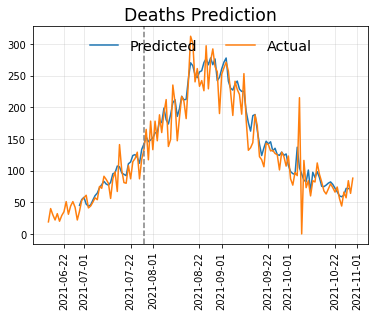

In [ ]:

death = pd.concat([y_multi_d_total,
                   data.Deaths_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
death.columns = ['multi_d', 'actual', 'Date']
tick_spacing = 5
date_test = data['Date'][0+index+lag-1]


ax = plt.axes()
plt.plot(death['Date'],death['multi_d'], label = "Predicted")
plt.plot(data['Date'],data['Deaths_daily'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Deaths Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


### Result Table

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Deaths'],
                                                  [multi_de],
                                    [round(scores_multi_d1[1],3)],
                                    [round(scores_multi_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

## Future Predictions

---



In [ ]:
# Multivariate
def future_prediction_multi(input, model, days_predicted, total_prediction):
  all_prediction = pd.DataFrame(total_prediction)

  # use the last 14 days from actual data
  all_input = input[-14:]

  for i in range(1,days_predicted + 1):
    # create a matrix of input with 14 previous days for all features
    new_input = np.expand_dims(all_input[-14:], axis = 0) 

    # set seed
    seed(1)
    tensorflow.random.set_seed(1)

    # make the next day prediction
    last_output = pd.DataFrame(model.predict(new_input))

    # record the prediction
    all_prediction = pd.concat([all_prediction, pd.DataFrame(last_output)], ignore_index=True)


    # use resident to predict future resident using trained model
    new_predictor = pd.DataFrame(model_mob_resident.predict(np.array(all_input.iloc[-lag:, 1:]).reshape(1,lag,1)))

    # new row
    new_row = [last_output[0], new_predictor]
    new_row = list(itertools.chain(*new_row))

    # feed the new row back to data frame as new input
    all_input.loc[len(all_input)] = new_row
  return all_prediction


# train model for resident
seed(1)
tensorflow.random.set_seed(1)
model_mob_resident = Sequential()
model_mob_resident.add(SimpleRNN(128, activation='relu', input_shape=(X_tr_resident.shape[1], X_tr_resident.shape[2])))
model_mob_resident.add(Dense(1, activation = "linear"))
model_mob_resident.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_resident.fit(X_tr_resident, y_tr_resident, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


In [ ]:
days_predicted = 25

# multivariate confirmed deaths
multi_d_pred = future_prediction_multi(data_d, model_multi_d, days_predicted, y_multi_d_total)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plots

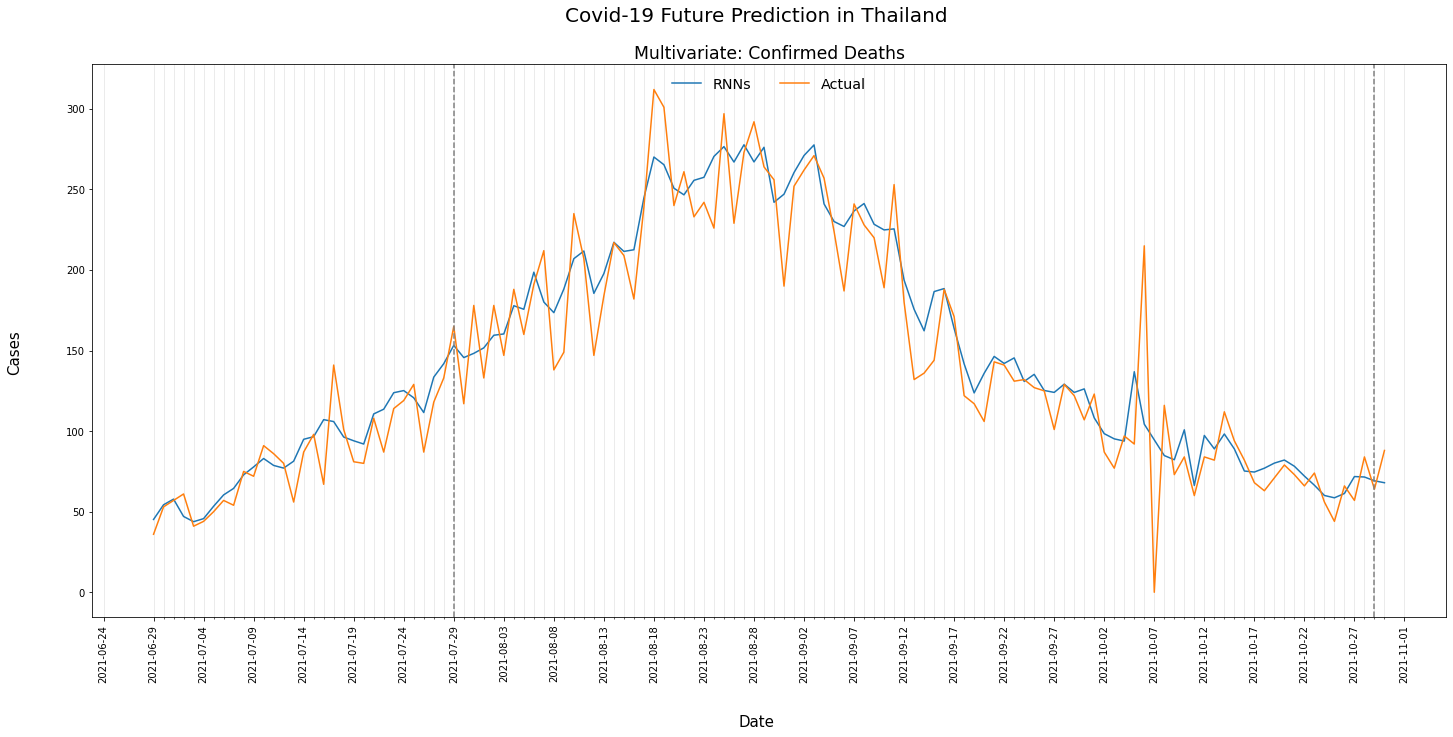

In [88]:

pred = pd.concat([multi_d_pred],
                 axis=1)
pred.columns = ['multi_d']

start_date = data.Date[lag]

# extract actual data
act = actual[(actual['Date'] >= start_date)].reset_index(drop = True)
act = act[0:len(pred)]


pred = pd.concat([pred, act], axis = 1)

date_test = pred['Date'][0+index]
date_predict = data['Date'][len(y_multi_d_total)+lag]
tick_spacing = 5

fig, axes = plt.subplots(figsize=(20,10)) 
fig.suptitle("Covid-19 Future Prediction in Thailand", fontsize=20)


# Multivariate confirmed deaths
axes.plot(pred['Date'],pred['multi_d'], label = multi_de)
axes.plot(pred['Date'], pred['Deaths_daily'], label = "Actual")
axes.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes.set_title("Multivariate: Confirmed Deaths", fontsize = 'xx-large')
axes.tick_params('x',labelrotation=90)
axes.axvline(date_test, color="gray", linestyle="--")
axes.axvline(date_predict, color="gray", linestyle="--")
axes.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes.set_xticks(pred['Date'], minor=True)
axes.xaxis.grid(True, which='both', alpha=0.3)

fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()